In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os


def results_plot_maker(ax, yvals, xvals, xlabel, ylabel, title, colors,
                       LABEL_FONTSIZE, TITLE_FONTSIZE, TICK_FONTSIZE,
                       use_fill_between=True,
                       fix_ticklabels=False,
                       model_top=None,
                       model_medium=None,
                       model_bottom=None, 
                       reverse=False, 
                       legend_labels=None):
    # here we assume we're plotting to a matplotlib axis object
    # and yvals is a LIST of arrays of size (n_runs, iterations),
    # where each can be different sized
    # and if xvals is given then len(xvals) == len(yvals)

    # set the labelling
    
    ax.set_xlabel(xlabel, fontsize=LABEL_FONTSIZE)
    ax.set_ylabel(ylabel, fontsize=LABEL_FONTSIZE)
    # ax.set_title(title, fontsize=TITLE_FONTSIZE)
    
    if legend_labels is None:
        labels = [None for i in range(len(colors))]
        zipper = zip(colors, xvals, yvals, labels)
    else:
        zipper = zip(colors, xvals, yvals, legend_labels)

    for color, x, Y, label in zipper:
        
        if reverse:
            Y = -Y
        bot, mid, top = [_.ravel() for _ in
                         np.percentile(Y, [25, 50, 75], axis=0)]
        if use_fill_between:
            ax.fill_between(x, bot.flat, top.flat, color=color, alpha=0.15)

        ax.plot(x, mid, color=color, label=label)
        ax.plot(x, bot, '--', color=color, alpha=0.15)
        ax.plot(x, top, '--', color=color, alpha=0.15)

    if model_top is not None:
        if use_fill_between:
            ax.fill_between(x, model_bottom.flat, model_top.flat, color=color, alpha=0.15)
        for x in xvals:
            ax.plot(x, model_top, '--', color=[158, 218, 229], alpha=0.15)
            ax.plot(x, model_bottom, '--', color=[158, 218, 229], alpha=0.15)
            ax.plot(x, model_medium, color=[158, 218, 229])

    # set the xlim
    min_x = np.min([np.min(x) for x in xvals])
    max_x = np.max([np.max(x) for x in xvals])
    ax.set_xlim([0, max_x + 1])

    ax.axvline(min_x, linestyle='dashed', color='gray', linewidth=1, alpha=0.5)

    ax.tick_params(axis='both', which='major', labelsize=TICK_FONTSIZE)
    ax.tick_params(axis='both', which='minor', labelsize=TICK_FONTSIZE)

    # set the alignment for outer ticklabels
    ax.set_xticks([0, 25, 50, 75, 100])
    if fix_ticklabels:
        ticklabels = ax.get_xticklabels()
        if len(ticklabels) > 0:
            ticklabels[0].set_ha("left")
            ticklabels[-1].set_ha("right")
    ax.legend()
    
    
model_list = [
    'BO',
    'BO_noise',
    'LinearBO',
    'LinearBO_noise',
    'LinearBOEarlyStop',
    'LinearBOEarlyStop_noise',
    'HyperoptOptimizer',
    'OpentunerOptimizer',
    'RandomOptimizer',
    'ScikitOptimizer'
]


tablau20 = np.array([
    [ 31, 119, 180], [255, 127,  14], [ 44, 160,  44], [214,  39,  40],
    [148, 103, 189], [140,  86,  75], [227, 119, 194], [127, 127, 127],
    [188, 189,  34], [ 23, 190, 207], [174, 199, 232], [255, 187, 120],
    [152, 223, 138], [255, 152, 150], [197, 176, 213], [196, 156, 148],
    [247, 182, 210], [199, 199, 199], [219, 219, 141], [158, 218, 229]
]) / 255.

mean_cols = tablau20[:len(model_list)]  # color bar

LABEL_FONTSIZE = 20
TITLE_FONTSIZE = 20
TICK_FONTSIZE = 15

def save_result_image(result_daraframes, result_daraframes_1, save_name):
    x_vals = []
    lengths = [result_dataframe.shape[1] for result_dataframe in result_daraframes]
    for i in range(len(result_daraframes)):
        x = np.arange(0, min(lengths), 1)
        x_vals.append(x)
        result_daraframes[i] = result_daraframes[i].iloc[:, :min(lengths)]
        
    fig, a = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=False)
    results_plot_maker(a[0], result_daraframes, x_vals, 'Iteration', save_name, 'Optimization result', mean_cols, LABEL_FONTSIZE, TITLE_FONTSIZE,
                       TICK_FONTSIZE, reverse=False, legend_labels=model_list)
    results_plot_maker(a[1], result_daraframes_1, x_vals, 'Iteration', None, 'Simple regret', mean_cols, LABEL_FONTSIZE, TITLE_FONTSIZE,
                       TICK_FONTSIZE, legend_labels=model_list)
    # plt.legend()
    plt.savefig(save_name+'.pdf', format='pdf')

    
def show_pic(result_dfs, name):
    # result_daraframes.append(contrast_result_dataframe)
    
    def transform_to_regret(dfs):
        maximum = 0
        for df in dfs:
            maximum = max(maximum, df.max().max())
        new_dfs = []
        for df in dfs:
            df = maximum - df
            for i in range(len(df)):
                for j in range(len(df.iloc[i])):
                    if j > 0 and df.iloc[i, j] > df.iloc[i, j-1]:
                        df.iloc[i, j] = df.iloc[i, j-1]
            new_dfs.append(df)
        return new_dfs
    result_daraframes_regret = transform_to_regret(result_dfs)
    save_result_image(result_dfs, result_daraframes_regret, name)
    

# Ablation 1: Linear mean GP vs. DKIBO

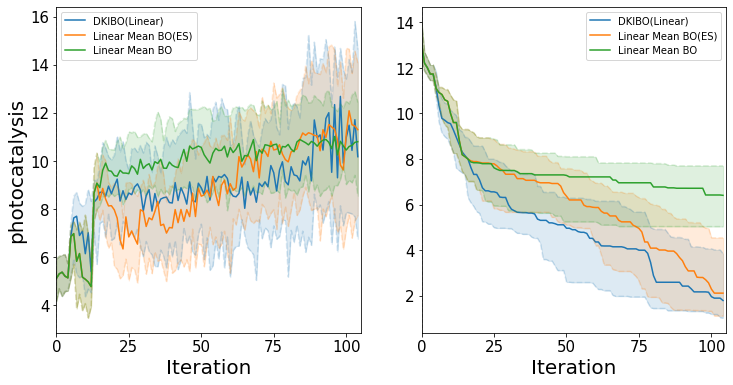

In [5]:
# plotting photocatalysis experiment
# 催化剂实验图生成
# todo: 增加EABO(rf)的图

import os


problem_name = 'photocatalysis_experiment'

base_path = r'C:\Users\darkn\PycharmProjects\SKBO\experiment_results_same_seed'

model_list = [
    # 'BO',
    # 'BO_noise',
    # 'LinearBO',
    # 'LinearBO_noise',
    # 'LinearBOEarlyStop',
    'LinearBOEarlyStop_noise',
]

result_dfs = []
for i in model_list:
    if 'noise' not in i:
        result_dfs.append(pd.read_csv(os.path.join(base_path, '{}_result_test_{}.csv'.format(i, problem_name)), index_col=0))
    else:
        result_dfs.append(pd.read_csv(os.path.join(base_path, '{}_result_test_{}_noise.csv'.format(i.strip('_noise'), problem_name)), index_col=0))
result_dfs.append(pd.read_csv(r'C:\Users\darkn\PycharmProjects\DKIBO\experiment_new_ablation\2023_2_23_18_22_ucb_2.576\LinearBO_result_test_photocatalysis_experiment.csv', index_col=0))
result_dfs.append(pd.read_csv(r'C:\Users\darkn\PycharmProjects\DKIBO\experiment_new_ablation\2023_2_23_19_1_no_early_stop_ucb_2.576\LinearBO_result_test_photocatalysis_experiment.csv', index_col=0))


# Change label names
model_list = [
    # 'Standard BO',
    'DKIBO(Linear)',
    'Linear Mean BO(ES)',
    'Linear Mean BO'
]
        

    
show_pic(result_dfs, name='photocatalysis')

# New Experiment: Data from GYM

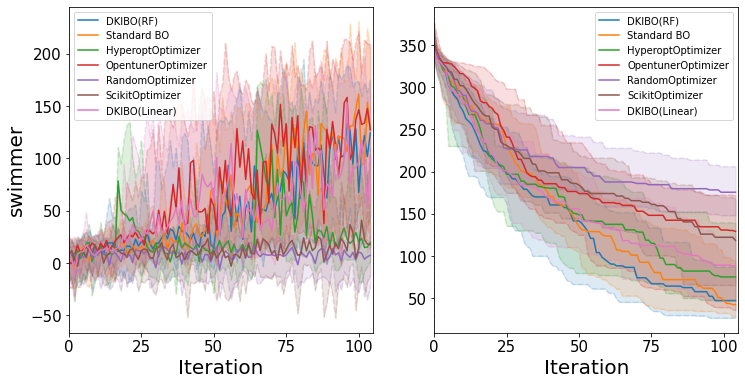

In [9]:
PATH = r'C:\Users\darkn\PycharmProjects\DKIBO\experiment_new_ablation\2023_2_28_13_42_no_early_stop'

result_dfs = [
    pd.read_csv(os.path.join(PATH, 'RFBO_result_test_swimmer_experiment.csv'), index_col=0),
    pd.read_csv(os.path.join(PATH,'standardBO_result_test_swimmer_experiment.csv'), index_col=0),
    pd.read_csv(os.path.join(PATH,'HyperoptOptimizer_result_test_swimmer_experiment.csv'), index_col=0),
    pd.read_csv(os.path.join(PATH,'OpentunerOptimizer_result_test_swimmer_experiment.csv'), index_col=0),
    pd.read_csv(os.path.join(PATH,'RandomOptimizer_result_test_swimmer_experiment.csv'), index_col=0),
    pd.read_csv(os.path.join(PATH,'ScikitOptimizer_result_test_swimmer_experiment.csv'), index_col=0),
    pd.read_csv(r'C:\Users\darkn\PycharmProjects\DKIBO\experiment_new_ablation\2023_3_1_18_7_ucb_2.576\LinearBO_result_test_swimmer_experiment.csv', index_col=0)
]

model_list = [
    'DKIBO(RF)',
    'Standard BO',
    'HyperoptOptimizer',
    'OpentunerOptimizer',
    'RandomOptimizer',
    'ScikitOptimizer',
    'DKIBO(Linear)'
]

show_pic(result_dfs, name='swimmer')

# Ablation 2: DKIBO ablation for photocatalysis

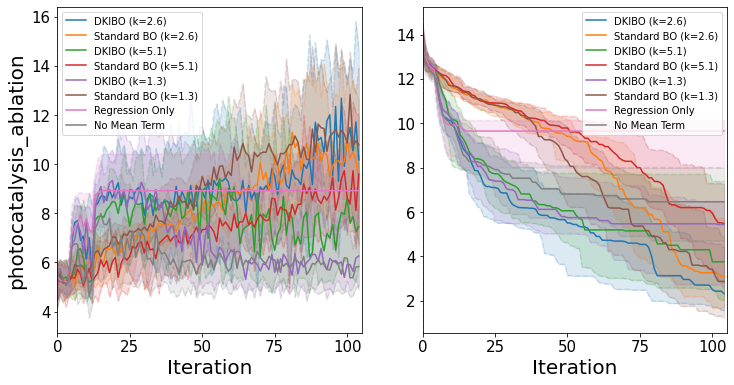

In [22]:
result_dfs = [
    pd.read_csv(r'C:\Users\darkn\PycharmProjects\SKBO\experiment_results_same_seed\LinearBOEarlyStop_result_test_photocatalysis_experiment_noise.csv', index_col=0),
    
    pd.read_csv(r'C:\Users\darkn\PycharmProjects\SKBO\experiment_results_same_seed\BO_result_test_photocatalysis_experiment.csv', index_col=0),
    pd.read_csv(r'C:\Users\darkn\PycharmProjects\DKIBO\experiment_results_for_bo_variants\2023_2_27_11_14_ucb_5.152\LinearBO_result_test_photocatalysis_experiment_5.152.csv', index_col=0),
    
    pd.read_csv(r'C:\Users\darkn\PycharmProjects\DKIBO\experiment_results_for_bo_variants\2023_2_27_11_14_ucb_5.152\standardBO_result_test_photocatalysis_experiment_5.152.csv', index_col=0),
    pd.read_csv(r'C:\Users\darkn\PycharmProjects\DKIBO\experiment_results_for_bo_variants\2023_2_27_11_14_ucb_1.288\LinearBO_result_test_photocatalysis_experiment_1.288.csv', index_col=0),
    pd.read_csv(r'C:\Users\darkn\PycharmProjects\DKIBO\experiment_results_for_bo_variants\2023_2_27_11_14_ucb_1.288\standardBO_result_test_photocatalysis_experiment_1.288.csv', index_col=0),
    
    pd.read_csv(r'C:\Users\darkn\PycharmProjects\DKIBO\experiment_results_for_bo_variants\2023_2_27_11_14_regression_only_2.576\LinearBO_result_test_photocatalysis_experiment_2.576.csv', index_col=0),
    pd.read_csv(r'C:\Users\darkn\PycharmProjects\DKIBO\experiment_results_for_bo_variants\2023_2_27_11_14_ucb_without_mean_2.576\LinearBO_result_test_photocatalysis_experiment_2.576.csv', index_col=0),
    ]

model_list = [
    'DKIBO (k=2.6)',
    'Standard BO (k=2.6)',
    'DKIBO (k=5.1)',
    'Standard BO (k=5.1)',
    'DKIBO (k=1.3)',
    'Standard BO (k=1.3)',
    'Regression Only',
     'No Mean Term',
]

show_pic(result_dfs, name='photocatalysis_ablation')

# Ablation 3: Gym swimmer ablation

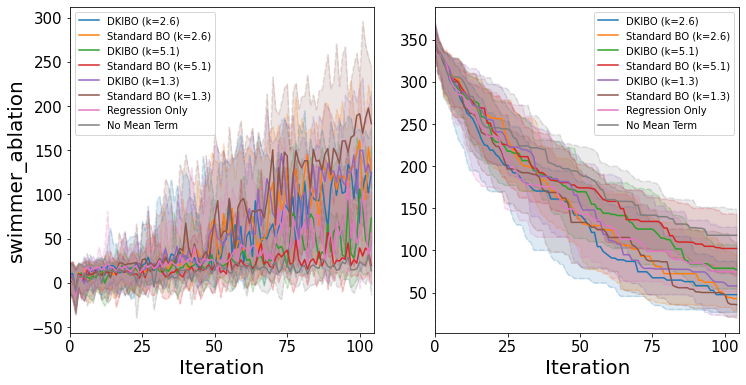

In [3]:
result_dfs = [
    pd.read_csv(r'C:\Users\darkn\PycharmProjects\DKIBO\experiment_new_ablation\2023_2_28_13_42_no_early_stop\RFBO_result_test_swimmer_experiment.csv', index_col=0),
    pd.read_csv(r'C:\Users\darkn\PycharmProjects\DKIBO\experiment_new_ablation\2023_2_28_13_42_no_early_stop\standardBO_result_test_swimmer_experiment.csv', index_col=0),
    pd.read_csv(r'C:\Users\darkn\PycharmProjects\DKIBO\experiment_new_ablation\2023_3_2_19_53_ucb_5.152\RFBO_result_test_swimmer_experiment.csv', index_col=0),
    pd.read_csv(r'C:\Users\darkn\PycharmProjects\DKIBO\experiment_new_ablation\2023_3_2_19_53_ucb_5.152\standardBO_result_test_swimmer_experiment.csv', index_col=0),
    pd.read_csv(r'C:\Users\darkn\PycharmProjects\DKIBO\experiment_new_ablation\2023_3_2_19_53_ucb_1.288\RFBO_result_test_swimmer_experiment.csv', index_col=0),
    pd.read_csv(r'C:\Users\darkn\PycharmProjects\DKIBO\experiment_new_ablation\2023_3_2_19_53_ucb_1.288\standardBO_result_test_swimmer_experiment.csv', index_col=0),
    pd.read_csv(r'C:\Users\darkn\PycharmProjects\DKIBO\experiment_new_ablation\2023_3_2_19_53_regression_only_2.576\RFBO_result_test_swimmer_experiment.csv', index_col=0),
    pd.read_csv(r'C:\Users\darkn\PycharmProjects\DKIBO\experiment_new_ablation\2023_3_2_19_53_ucb_without_mean_2.576\RFBO_result_test_swimmer_experiment.csv', index_col=0),
]

model_list = [
    'DKIBO (k=2.6)',
    'Standard BO (k=2.6)',
    'DKIBO (k=5.1)',
    'Standard BO (k=5.1)',
    'DKIBO (k=1.3)',
    'Standard BO (k=1.3)',
    'Regression Only',
     'No Mean Term',
]

show_pic(result_dfs, name='swimmer_ablation')

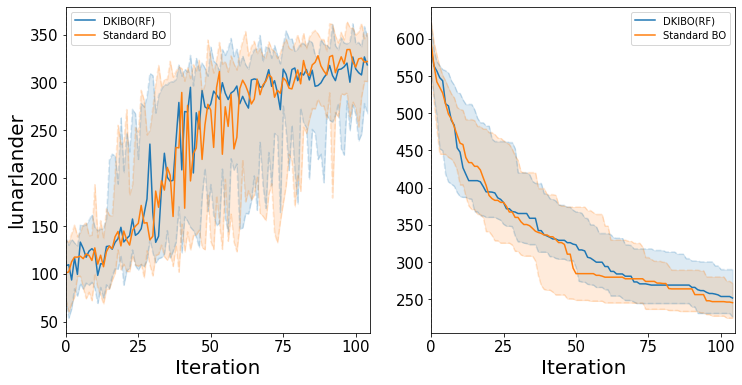

In [8]:
PATH = r'C:\Users\darkn\PycharmProjects\DKIBO\experiment_new_ablation\2023_2_28_13_42_no_early_stop'

result_dfs = [
    pd.read_csv(os.path.join(PATH, 'RFBO_result_test_lunarlander_problem.csv'), index_col=0),
    pd.read_csv(os.path.join(PATH,'standardBO_result_test_lunarlander_problem.csv'), index_col=0),
    # pd.read_csv(os.path.join(PATH,'HyperoptOptimizer_result_test_lunarlander_problem.csv'), index_col=0),
    # pd.read_csv(os.path.join(PATH,'OpentunerOptimizer_result_test_lunarlander_problem.csv'), index_col=0),
    # pd.read_csv(os.path.join(PATH,'RandomOptimizer_result_test_lunarlander_problem.csv'), index_col=0),
    # pd.read_csv(os.path.join(PATH,'ScikitOptimizer_result_test_lunarlander_problem.csv'), index_col=0)
]

model_list = [
    'DKIBO(RF)',
    'Standard BO',
    # 'HyperoptOptimizer',
    # 'OpentunerOptimizer',
    # 'RandomOptimizer',
    # 'ScikitOptimizer'
]

show_pic(result_dfs, name='lunarlander')